In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import theano
import theano.tensor as T
import lasagne as L

from IPython import display

from util import *
from quadratic import QuadraticFunction_Tensor

Using gpu device 1: Tesla K40m (CNMeM is disabled, cuDNN 5105)


In [2]:
%run ../lstm_optimizer_params.py
%run ../ntm_bfgs_optimizer_params.py
%run ../chain_optimizer.py

In [3]:
#A = T.scalar()
#B = T.scalar()
W_sym = T.tensor3('W')
b_sym = T.matrix('b')

func = lambda theta, W, b: QuadraticFunction_Tensor(theta, W, b).func

In [4]:
options = {
    'num_units': 20,
    'function': func,
    'n_layers': 2,
    'preprocess_input': False,
    'gradient_steps': 20,
    'gradient_clipping': 1,
    'loglr': True,
}

In [6]:
def sample_point(ndim, *args):
    return np.random.normal(size=ndim)

def sample_params(ndim, *args):
    W = np.random.normal(size=(ndim, ndim))
    b = np.random.normal(size=ndim)
    return W, b

def sample_point_and_params(ndim=None, sample_point=sample_point):
    params = sample_params(ndim)
    theta = sample_point(ndim, *params)
    
    return theta, params

def random_direction(ndim):
    d = np.random.normal(size=ndim)
    d /= np.sqrt((d**2).sum())
    return d

def random_direction(ndim, num=1):
    d = np.random.normal(size=(num, ndim))
    d /= np.sqrt((d**2).sum(axis=1, keepdims=True))
    return d

def grid_sampler(n_functions, d, num=100):
    problems = {}
    for _ in range(n_functions):
        ndim = np.random.randint(2, 10)
#         ndim = 2
        W, b = sample_params(ndim)
        solution = np.linalg.pinv(W).dot(-b)
                
        random_dir = random_direction(ndim, num)
        random_dir /= np.sqrt((random_dir.dot(W.T)**2).sum(axis=1, keepdims=True))
            
        points = solution.reshape(1, -1) + d * random_dir
        Ws = np.tile(W, (num, 1, 1))
        bs = np.tile(b, (num, 1))
        
        if problems.get(ndim) is None:
            problems[ndim] = (points, Ws, bs)
        else:
            old_p, old_W, old_b = problems[ndim]
            problems[ndim] = (np.vstack([old_p, points]), np.vstack([old_W, Ws]), np.vstack([old_b, bs]))
        
#         for i in range(num):
#             theta = solution + d * random_direction(ndim)
#             problems.setdefault(ndim, []).append((theta, W, b))
        
    #return {ndim: [np.array(p) for p in zip(*arr)] for ndim, arr in problems.items()}
    return problems
#     return list(map(np.array, zip(*problems)))

def multisampler(n, ndim, *args):
    W = np.random.normal(size=(n, ndim, ndim))
    b = np.random.normal(size=(n, ndim))
    theta = np.random.normal(size=(n, ndim))
    return theta, W, b

In [13]:
_thetas = {}
_Ws = {}
_bs = {}

#for d in [1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4]:
for d in [1e1, 1e0, 1e-1, 1e-2, 1e-3, 1e-4]:
    sampled_problems = grid_sampler(100, d, 400)
    
    for ndim in sampled_problems:
        _theta, _W, _b = sampled_problems[ndim]
    
        _thetas.setdefault(ndim, []).append(_theta)
        _Ws.setdefault(ndim, []).append(_W)
        _bs.setdefault(ndim, []).append(_b)

# train_inputs = np.concatenate(_thetas), np.concatenate(_Ws), np.concatenate(_bs)

Time compiling value_fn: 0.19842171669006348


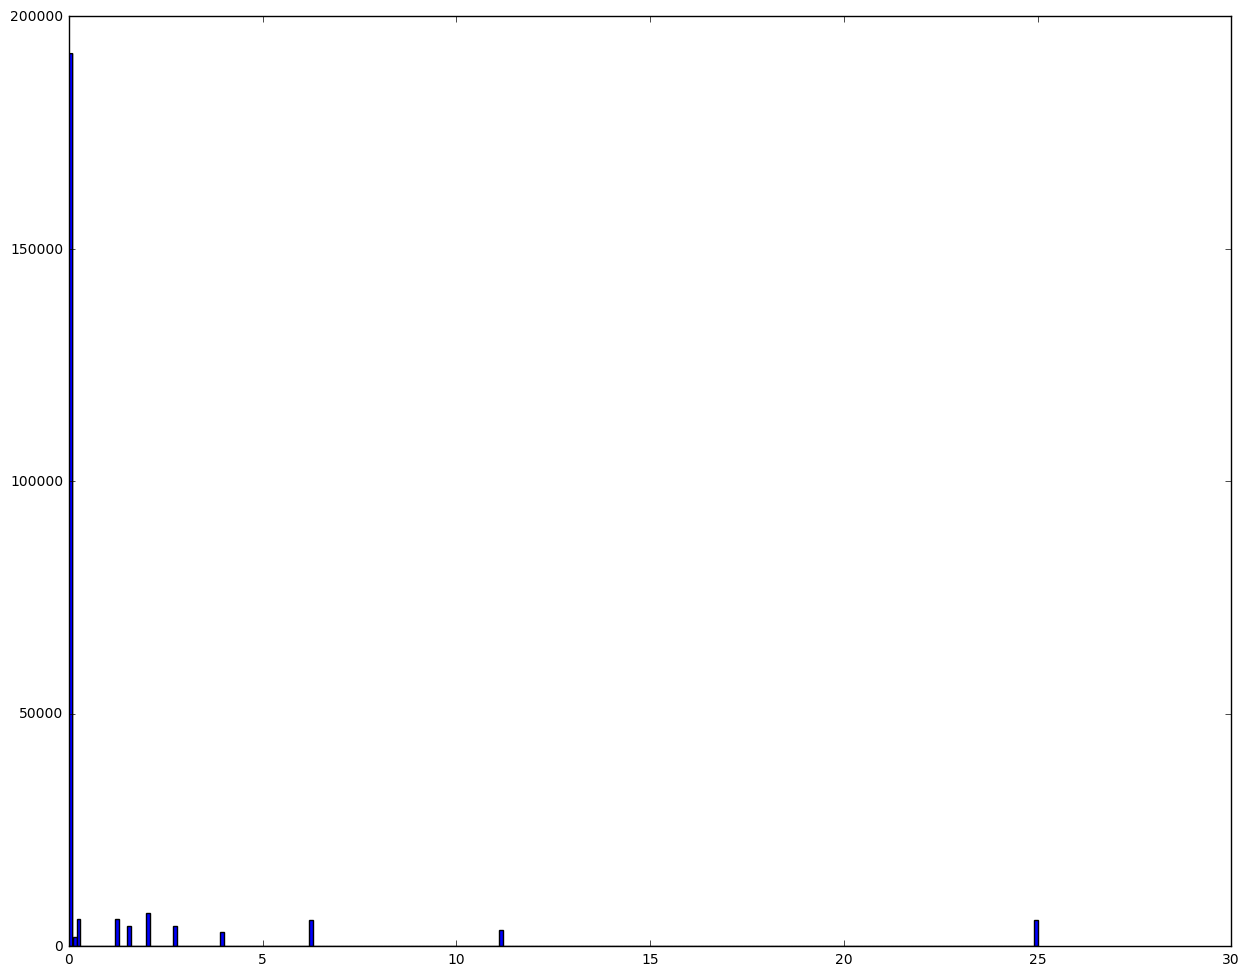

In [15]:
opt = LSTM_Optimizer(params_input=[W_sym, b_sym], **options)
opt.prepare_value_fn()

train_inputs = {
    ndim: (np.concatenate(_thetas[ndim]), np.concatenate(_Ws[ndim]), np.concatenate(_bs[ndim]))
    for ndim in _thetas
}

values_dict = {
    ndim: opt.value_fn(*train_inputs[ndim]) 
    for ndim in train_inputs
}

values = np.concatenate(list(values_dict.values()))

plt.figure(figsize=(15, 12))
plt.hist(values, bins=250);

In [20]:
partition = {
    ndim: get_partition(train_inputs[ndim], values_dict[ndim], [1e0, 1e-2, 1e-4, 1e-6, 1e-8], filter_empty=False) 
    for ndim in train_inputs
}

In [22]:
new_partition = {}

for ndim in partition:
    new_partition[ndim] = []
    
    for p in partition[ndim]:
        print(ndim, len(p[0]))
        indices = np.arange(len(p[0]))
        np.random.shuffle(indices)

        new_partition[ndim].append((p[0][indices][:1000], p[1][indices][:1000], p[2][indices][:1000]))

2 5600
2 6000
2 7200
2 5200
2 3600
2 6400
3 3600
3 2000
3 5600
3 6800
3 2800
3 4000
4 5600
4 6400
4 5200
4 5200
4 4400
4 5200
5 3200
5 6800
5 4800
5 3600
5 7600
5 3600
6 4400
6 6000
6 2800
6 5200
6 6000
6 4400
7 7200
7 4400
7 4400
7 4400
7 4400
7 5600
8 4400
8 4800
8 5600
8 4400
8 5200
8 5600
9 6000
9 3600
9 4400
9 5200
9 6000
9 5200


In [23]:
options['n_gac'] = 0
n_opt = max(len(partition[ndim]) for ndim in new_partition) 
opts = [LSTM_Optimizer(scale_output=2**(-i), params_input=[W_sym, b_sym], **options) for i in range(n_opt)]
chain_optimizer = ChainOptimizer(opts, n_small_steps=20)

In [24]:
print(n_opt)

6


In [25]:
chain_optimizer.prepare(loss_type='sum', start_lr=0.001)

Time compiling value_fn: 0.19221782684326172
Time compiling loss_fn: 4.585391998291016
Time compiling train_fn: 84.70877075195312
Time compiling value_fn: 0.18703031539916992
Time compiling loss_fn: 2.989544630050659
Time compiling train_fn: 87.81218719482422
Time compiling value_fn: 0.16202425956726074
Time compiling loss_fn: 4.883989572525024
Time compiling train_fn: 84.48936104774475
Time compiling value_fn: 0.22420144081115723
Time compiling loss_fn: 2.9844655990600586
Time compiling train_fn: 85.58316159248352
Time compiling value_fn: 0.18312430381774902
Time compiling loss_fn: 2.9447314739227295
Time compiling train_fn: 97.08465623855591
Time compiling value_fn: 0.2368781566619873
Time compiling loss_fn: 2.913386821746826
Time compiling train_fn: 94.75809097290039


In [26]:
# train_inputs = multisampler(8000, 2)
val_inputs = multisampler(8000, 20)

In [27]:
n_epochs   = 30
batch_size = 400

training_options = {
    'n_epochs'  : n_epochs,
    'batch_size': batch_size,
    'decay_rate': 1.0,
    'verbose': True
}

iterations = [20]
n_functions = n_epochs * batch_size

In [ ]:
losses = []

for j in range(n_opt):
    chain_optimizer.opts[j].lr.set_value(0.01)
    chain_optimizer.opts[j].reset_network()
    
    training_options['n_iter'] = 20
    
    train_loss = []
    
    for ndim in new_partition:
        opt_loss, val_loss = chain_optimizer.opts[j].train(new_partition[ndim][j], val_inputs, **training_options)
        train_loss += opt_loss
    
    losses.append((train_loss, val_loss))

Epoch number 0
	Time: 1.686457872390747
	Optimizer loss: 254.38060193454263
	Median final loss: 4.739040374755859
	Validation loss: 16.127275100945493
Epoch number 1
	Time: 1.6782677173614502
	Optimizer loss: 177.78271810864894
	Median final loss: 2.1616244316101074
	Validation loss: 12.468490858335048
Epoch number 2
	Time: 1.6996262073516846
	Optimizer loss: 167.85833581963666
	Median final loss: 0.9506465792655945
	Validation loss: 11.825818069931119
Epoch number 3
	Time: 1.6635017395019531
	Optimizer loss: 144.6823235962803
	Median final loss: 1.3016059398651123
	Validation loss: 12.519319908161648
Epoch number 4
	Time: 1.6684558391571045
	Optimizer loss: 129.62191421954344
	Median final loss: 1.2676845788955688
	Validation loss: 7.694718521810951
Epoch number 5
	Time: 1.679826021194458
	Optimizer loss: 121.46103089278326
	Median final loss: 0.7311530411243439
	Validation loss: 7.226687212001183
Epoch number 6
	Time: 1.6685750484466553
	Optimizer loss: 114.91210590526457
	Median fin

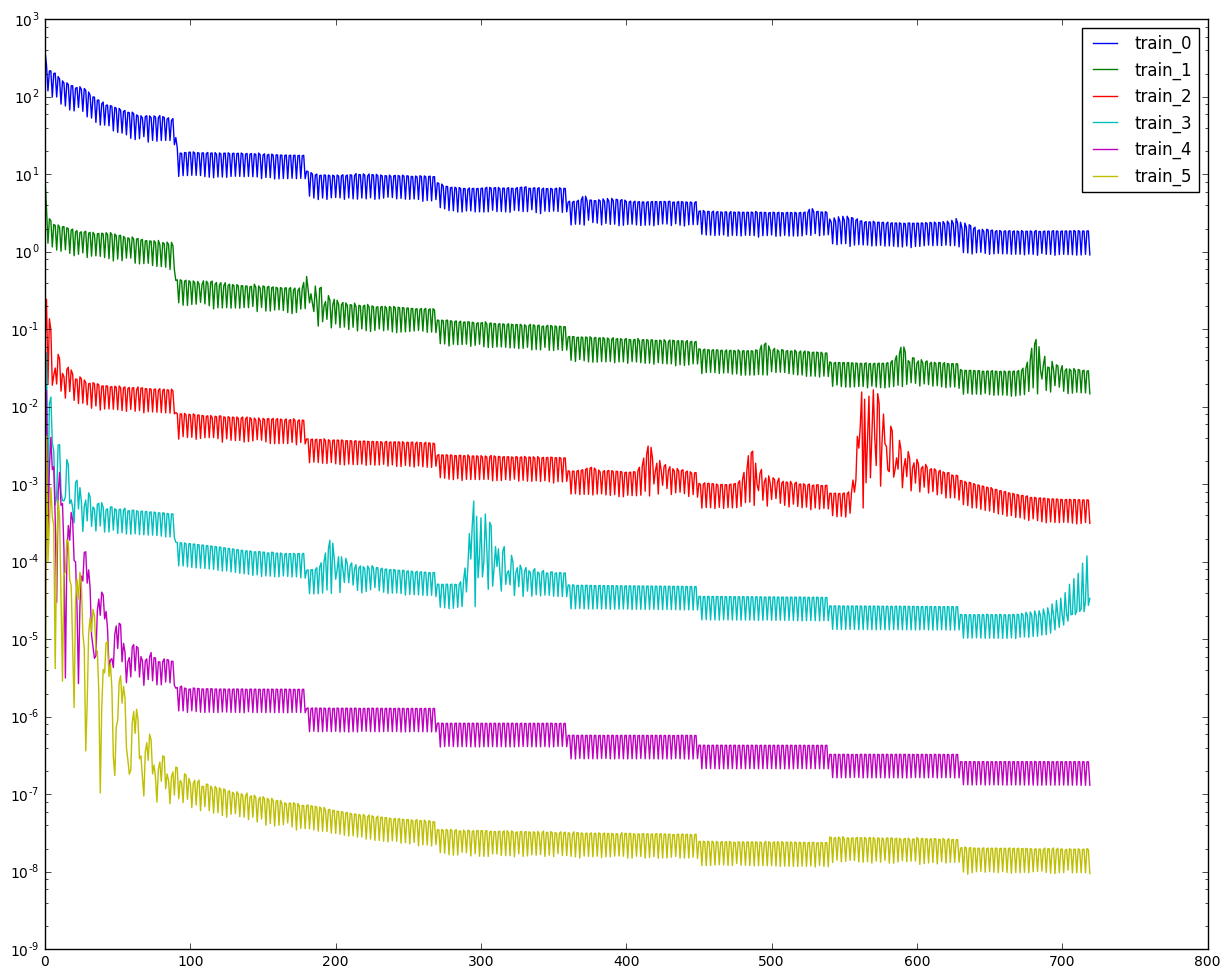

In [ ]:
plt.figure(figsize=(15, 12))
for k, (train_loss, val_loss) in enumerate(losses):
    plt.semilogy(train_loss, label='train_{}'.format(k))
plt.legend();

In [ ]:
from quadratic import QuadraticFunction

W_ = T.matrix('W')
b_ = T.vector('b')
func_ = lambda theta: QuadraticFunction(theta, W_, b_).func

sgd_fn = make_sgd(func_, var=[W_, b_])
momentum_fn = make_momentum(func_, var=[W_, b_])
lbfgs_fn = make_lbfgs(func_, m=10, init_lr=2e-4, var=[W_, b_])

non_lstm_optimizers = {
    'sgd': sgd_fn,
    'momentum': momentum_fn, 
    'lbfgs': lbfgs_fn
}

In [ ]:
lstm_optimizers = {'chain': chain_optimizer}

In [ ]:
from collections import namedtuple
TestCase = namedtuple('TestCase', 'n_iter n_functions')

In [ ]:
tests = [
    TestCase(n_iter=20, n_functions=50), 
    TestCase(n_iter=60, n_functions=50),
    TestCase(n_iter=500, n_functions=50),
    TestCase(n_iter=500, n_functions=1)
]

tests_results = []

for n_iter, n_functions in tests:
    testing_options = {
        'n_iter'     : n_iter,
        'n_functions': n_functions,
        'sampler'    : lambda batch_size: multisampler(batch_size, 10),
        'normalize': True
    }
    histories = test_optimizers(lstm_optimizers, non_lstm_optimizers, **testing_options)
    tests_results.append(histories)

Testing lstm; chain
Testing momentum
Testing sgd
Testing lbfgs
Testing lstm; chain
Testing momentum
Testing sgd
Testing lbfgs
Testing lstm; chain
Testing momentum
Testing sgd
Testing lbfgs
Testing lstm; chain
Testing momentum
Testing sgd
Testing lbfgs


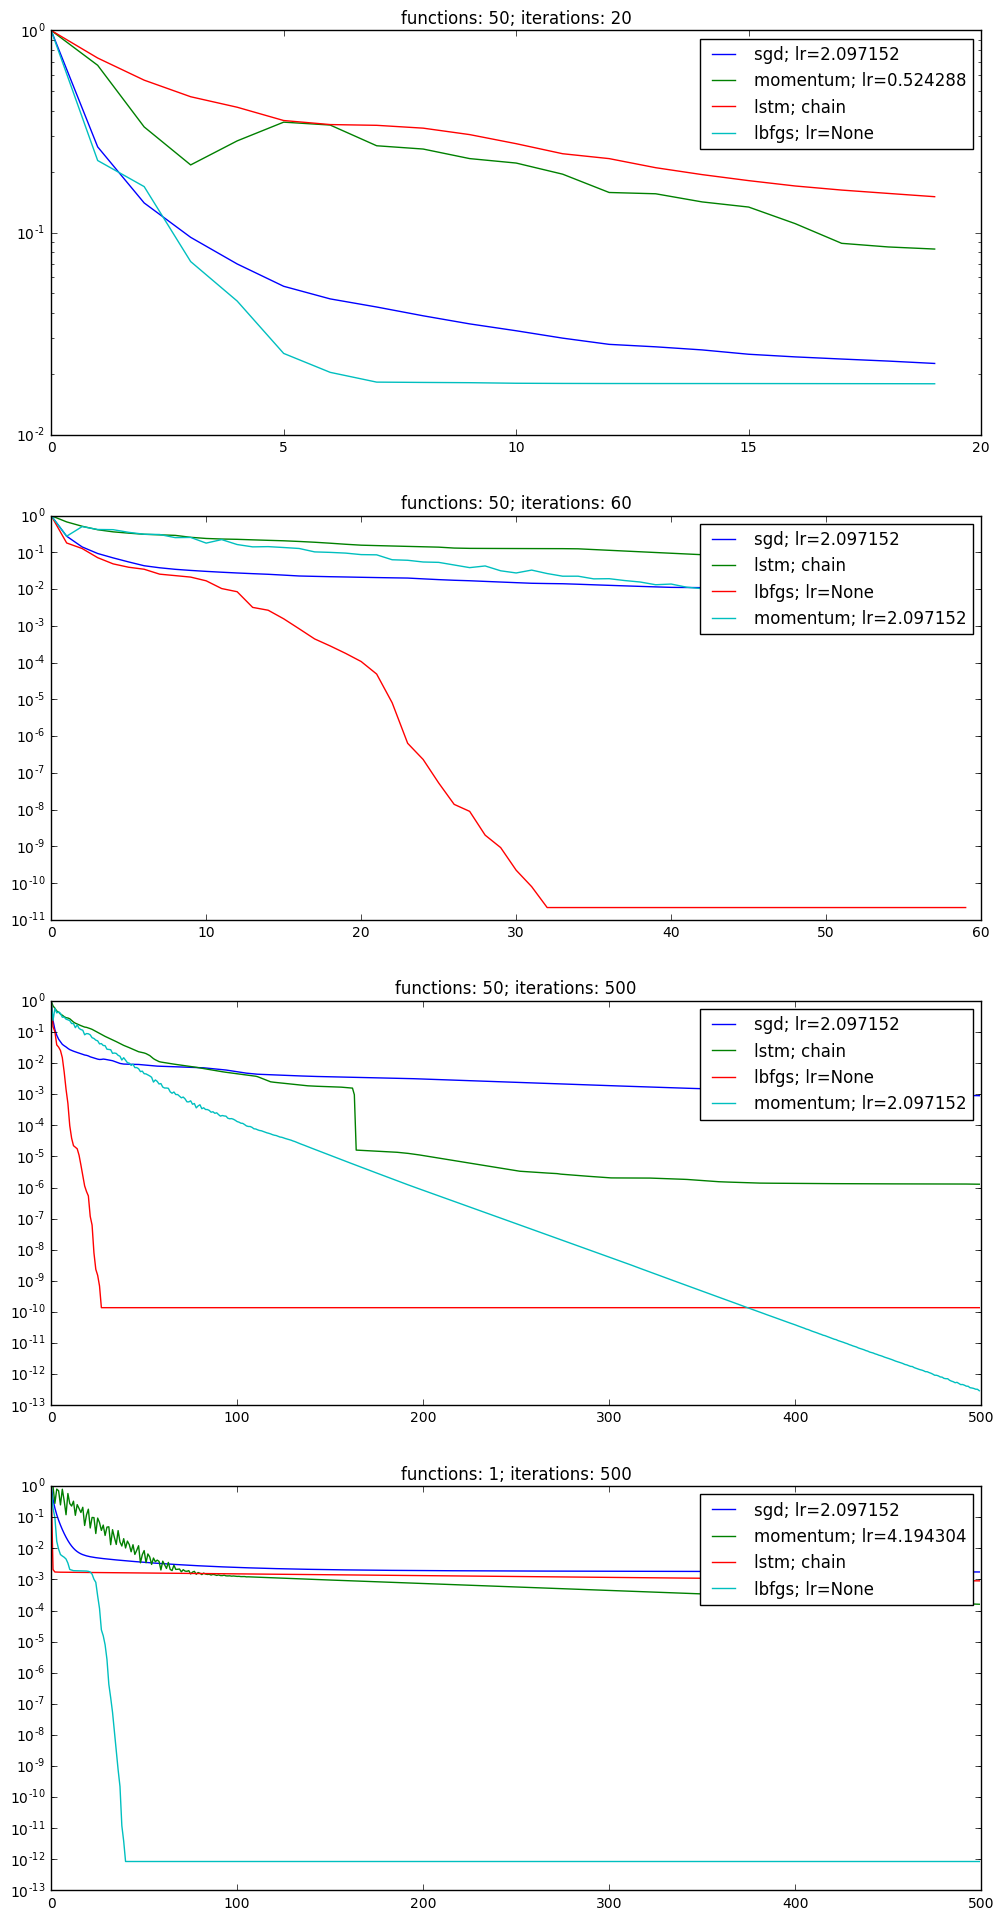

In [ ]:
%matplotlib inline
fig, axes = plt.subplots(len(tests_results), figsize=(12, 6 * len(tests_results)))

if len(tests_results) == 1:
    axes = (axes,)

for ax, (n_iter, n_functions), h in zip(axes, tests, tests_results):
    for name, hist in h.items():
        ax.semilogy(hist, label=name)
    
    ax.set_title('functions: {}; iterations: {}'.format(n_functions, n_iter))
    ax.legend()
    
# fig.tight_layout()

In [ ]:
tests_results_3 = []

for n_iter, n_functions in tests:
    testing_options = {
        'n_iter'     : n_iter,
        'n_functions': n_functions,
        'sampler'    : lambda batch_size: multisampler(batch_size, 2),
        'normalize': True
    }
    histories = test_optimizers(lstm_optimizers, non_lstm_optimizers, **testing_options)
    tests_results_3.append(histories)

Testing lstm; chain
Testing momentum
Testing sgd
Testing lbfgs
Testing lstm; chain


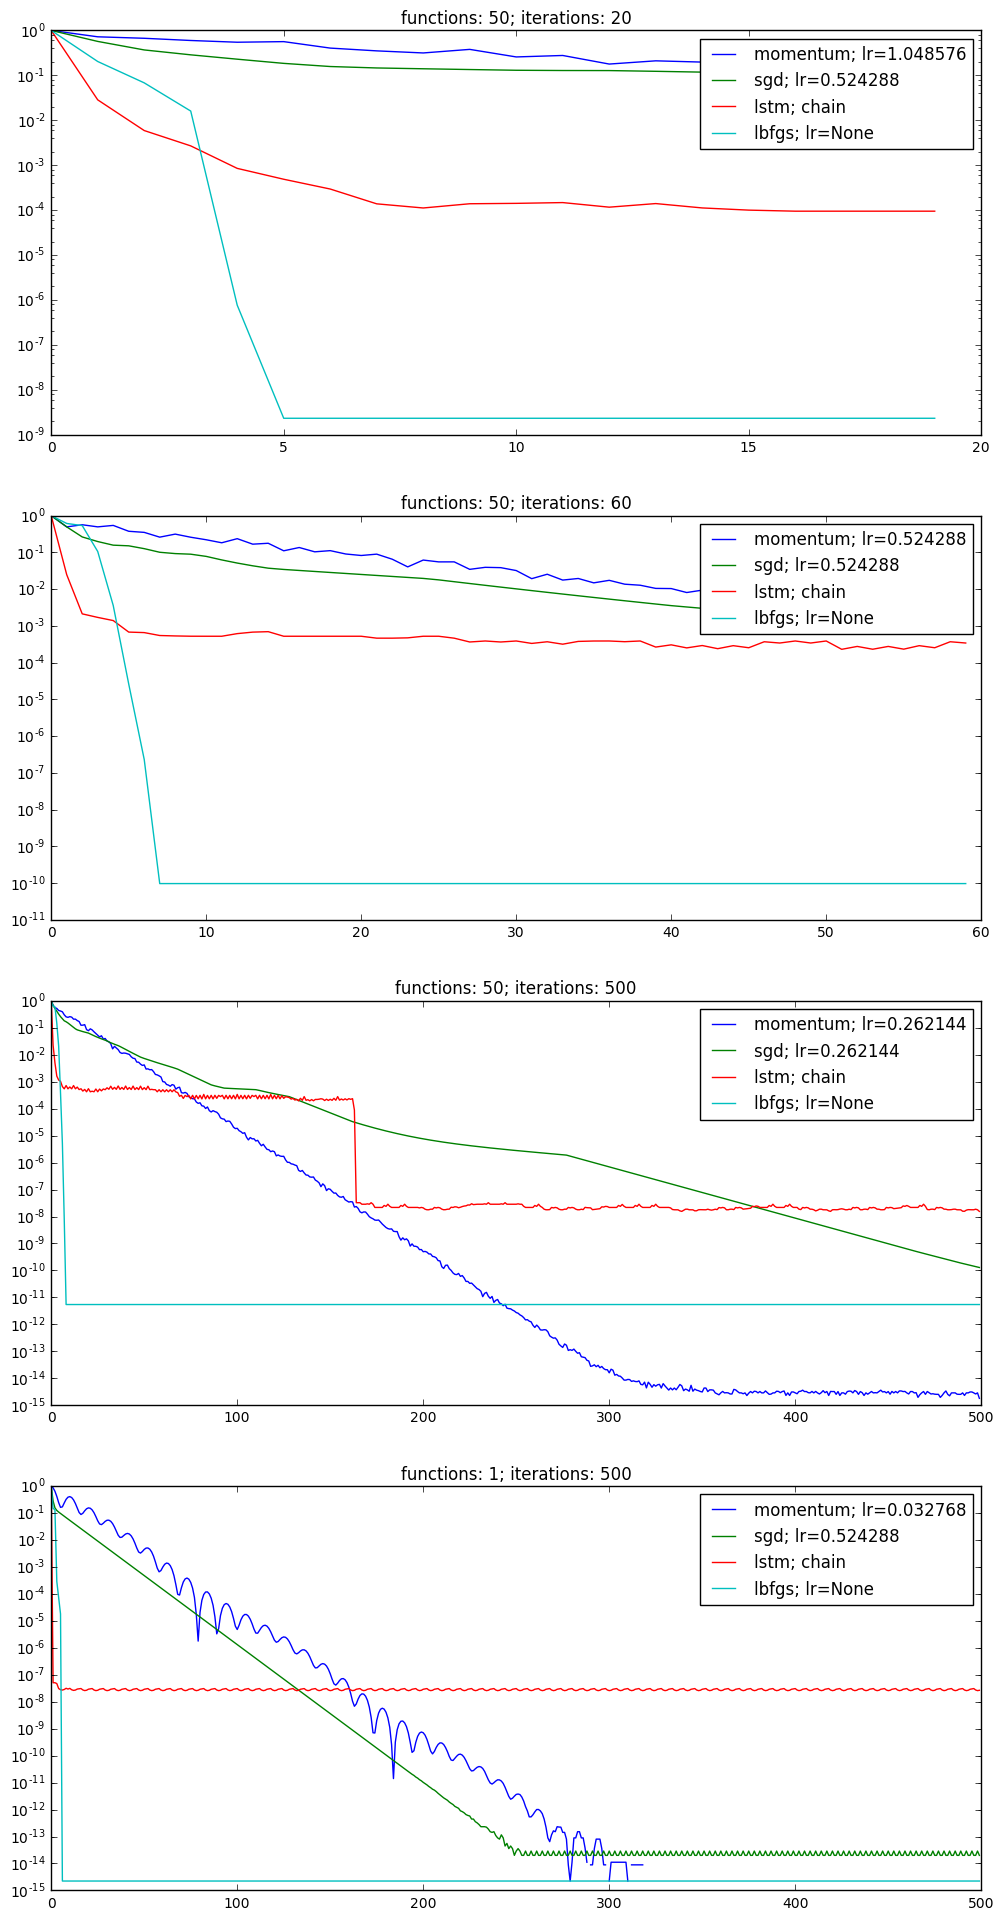

In [41]:
fig, axes = plt.subplots(len(tests_results_3), figsize=(12, 6 * len(tests_results_3)))

if len(tests_results_3) == 1:
    axes = (axes,)

for ax, (n_iter, n_functions), h in zip(axes, tests, tests_results_3):
    for name, hist in h.items():
        ax.semilogy(hist, label=name)
    
    ax.set_title('functions: {}; iterations: {}'.format(n_functions, n_iter))
    ax.legend()

In [ ]:
tests_results_4 = []

for n_iter, n_functions in tests:
    testing_options = {
        'n_iter'     : n_iter,
        'n_functions': n_functions,
        'sampler'    : lambda batch_size: multisampler(batch_size, 100),
        'normalize': True
    }
    histories = test_optimizers(lstm_optimizers, non_lstm_optimizers, **testing_options)
    tests_results_4.append(histories)

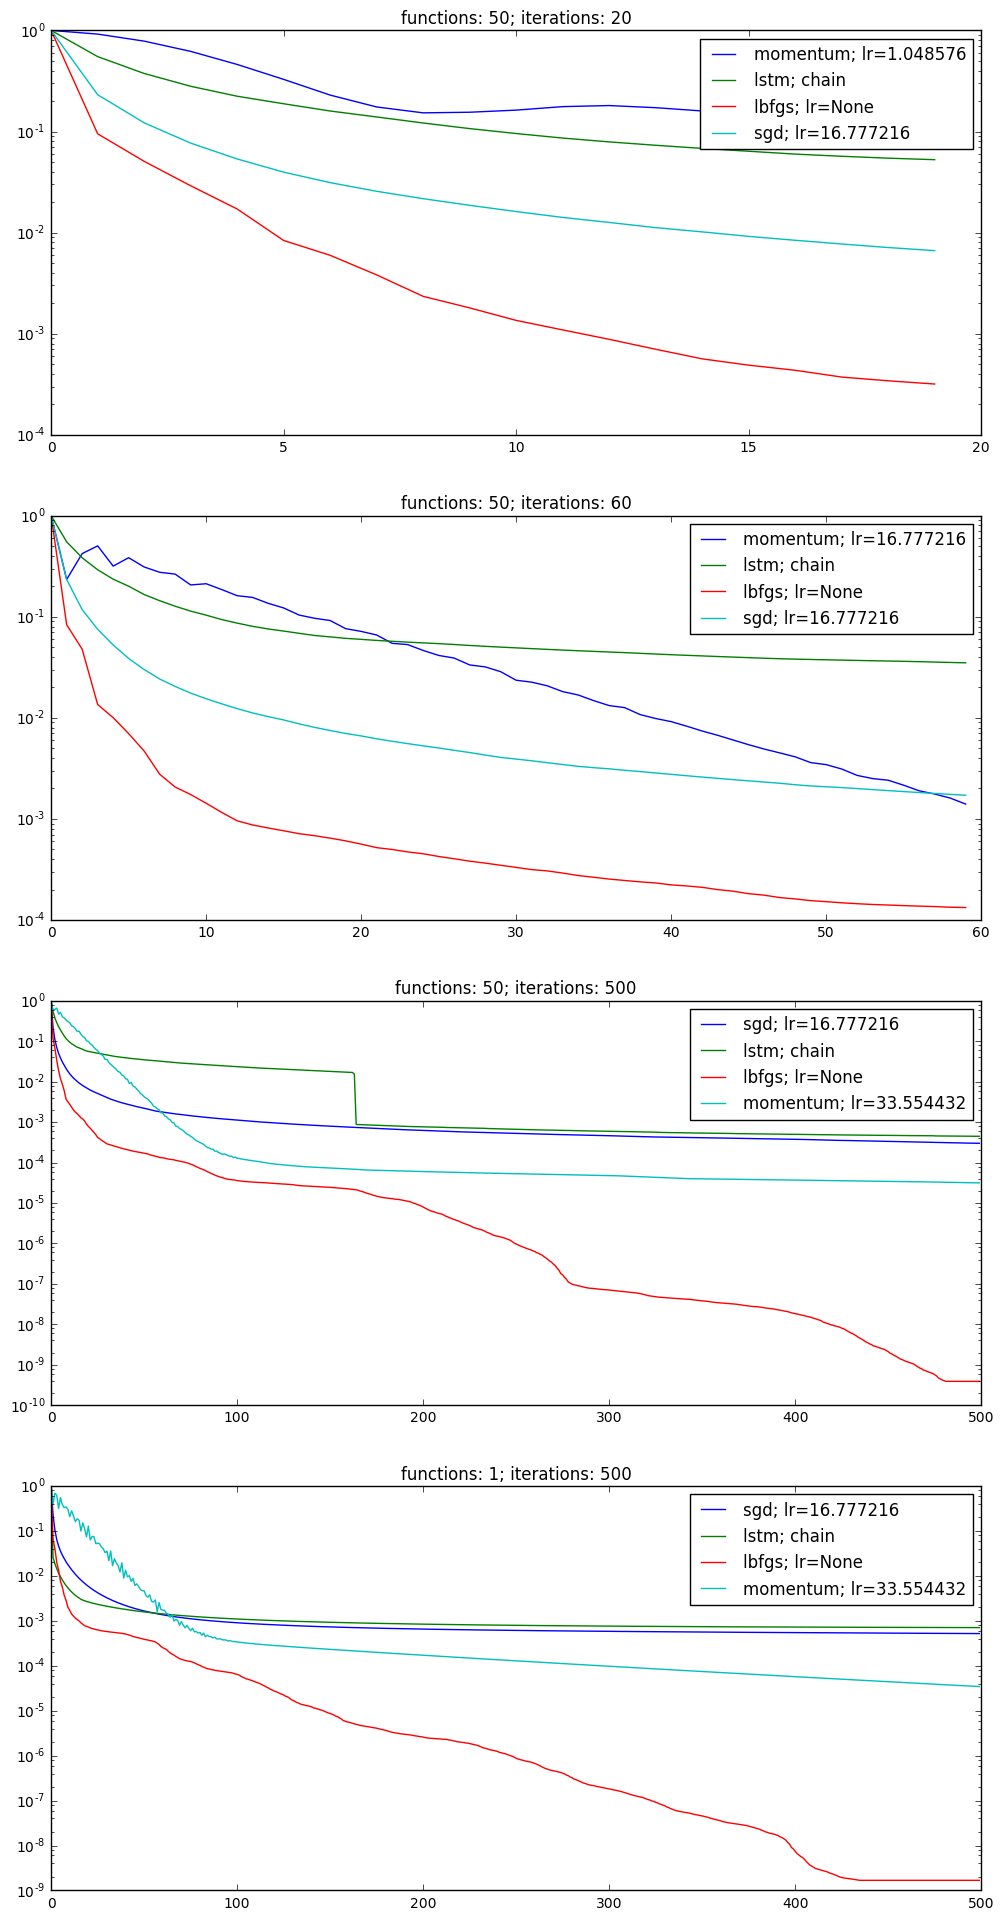

In [40]:
fig, axes = plt.subplots(len(tests_results_4), figsize=(12, 6 * len(tests_results_4)))

if len(tests_results_4) == 1:
    axes = (axes,)

for ax, (n_iter, n_functions), h in zip(axes, tests, tests_results_4):
    for name, hist in h.items():
        ax.semilogy(hist, label=name)
    
    ax.set_title('functions: {}; iterations: {}'.format(n_functions, n_iter))
    ax.legend()

In [ ]:
dim_losses = {
    'LSTM': [],
    'momentum': []
}

for ndim in range(2, 100):
    print(ndim)
    problems = multisampler(20, ndim)
    _, losses = chain_optimizer.optimize(problems[0], problems[1:], 500)
    
    dim_losses['LSTM'].append(np.median(losses[:, -1]))
    
    momentum_losses = []
    for theta, W, b in zip(*problems):
        _, losses = momentum_fn(theta, 500, W, b, 0.5)
        momentum_losses.append(losses[-1])
    
    dim_losses['momentum'].append(np.median(momentum_losses))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90


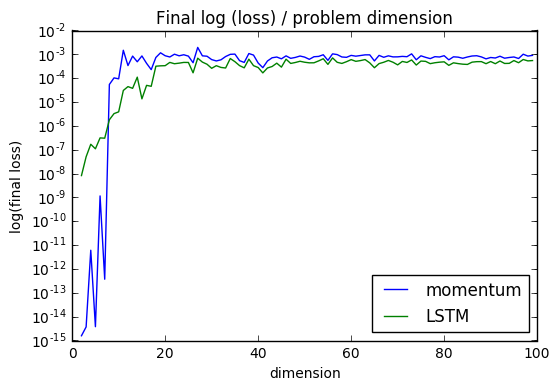

In [52]:
dims = list(range(2, 100))

plt.title('Final log (loss) / problem dimension')
plt.xlabel('dimension')
plt.ylabel('log(final loss)')

for name, losses in dim_losses.items():
    plt.semilogy(dims, losses, label=name)
plt.legend(loc=4);

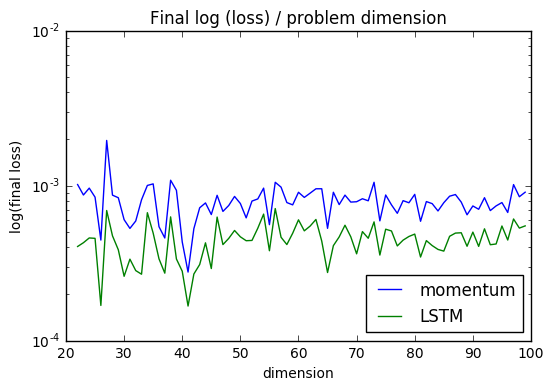

In [53]:
dims = list(range(2, 100))

plt.title('Final log (loss) / problem dimension')
plt.xlabel('dimension')
plt.ylabel('log(final loss)')

for name, losses in dim_losses.items():
    plt.semilogy(dims[20:], losses[20:], label=name)
plt.legend(loc=4);